[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/124MniOivPszhoPCXZycyG6uDMyJEgKDl/view?usp=sharing)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparameters
d_model= 512 # Embed size olarak da bilinir: token embedding vektörünün boyutu
nhead = 16 # Multi Head Attention katmanındaki head sayısı
num_encoder_layers = 6 # Encoderdaki EncoderStack sayısı
num_decoder_layers = 6 # Decoderdaki DecoderStack sayısı
forward_expansion= 4 # Transformer Encoder/Decoder içindeki ileri beslemeli ağdaki nöronların artış oranı
learning_rate = 3e-4 # Adam optimizer'ının learning rate değeri
context_len = 256 # Girdi dizisinin (maksimum) uzunluğu
dropout = 0.10 # Dropout katmanlarının atma oranı

In [ ]:
dataset_path = ".../Eğitim MYZE - Transformer Architecture/eng_-french.csv"
dataset = pd.read_csv(dataset_path,encoding="utf8")

french_vocab = ["^"]
english_vocab = ["^"]
a = False
for i in range(len(dataset)):
    french_out = list(set(dataset["French"][i]))
    english_out = list(set(dataset["English"][i]))
    if "^" in french_out or "^" in english_out:
      a = True
    for ch in french_out:
        if ch not in french_vocab:
            french_vocab.append(ch)
    for ch in english_out:
        if ch not in english_vocab:
            english_vocab.append(ch)

french_vocab = sorted(french_vocab)
english_vocab = sorted(english_vocab)

fr_stoi = {ch:i for i,ch in enumerate(french_vocab)}
fr_itos = {i:ch for i,ch in enumerate(french_vocab)}

en_stoi = {ch:i for i,ch in enumerate(english_vocab)}
en_itos = {i:ch for i,ch in enumerate(english_vocab)}

PAD_fr = fr_stoi["^"]
PAD_en = en_stoi["^"]

eng_vocab_size = len(english_vocab) # Kelime haznesinin boyutu (vocab_size) (Tokenizer tarafından bilinen token sayısı)
fr_vocab_size = len(french_vocab) # Kelime haznesinin boyutu (vocab_size) (Tokenizer tarafından bilinen token sayısı)

def tokenizer(string,stoi):
    result = []
    for ch in string:
        result.append(stoi[ch])
    if len(result) < context_len:
        result += [0]*(context_len-len(result))
    return torch.tensor(result, dtype=torch.long)
print(tokenizer("Bears never dance at the circus",en_stoi)[:30])

def decode_tokens(indexs,itos):
    result = ""
    for idx in indexs:
        result += itos[idx.item()]
    return result
print(decode_tokens(tokenizer("Bears never dance at the circus",en_stoi),en_itos))

print(fr_vocab_size)
print(eng_vocab_size)

tensor([26, 56, 52, 69, 70,  0, 65, 56, 73, 56, 69,  0, 55, 52, 65, 54, 56,  0,
        52, 71,  0, 71, 59, 56,  0, 54, 60, 69, 54, 72])
Bears never dance at the circus                                                                                                                                                                                                                                 
114
92


In [ ]:
encoded_english = []
for text in dataset["English"]:
    encoded_english.append(tokenizer(text,en_stoi))
print(encoded_english[0][:20])
print(decode_tokens(encoded_english[0],en_itos),"\n")

encoded_french = []
for text in dataset["French"]:
    encoded_french.append(tokenizer(text,fr_stoi))
print(encoded_french[0][:20])
print(decode_tokens(encoded_french[0],fr_itos),"\n")

tensor([32, 60, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])
Hi.                                                                                                                                                                                                                                                              

tensor([45, 54, 65, 74, 73,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])
Salut!                                                                                                                                                                                                                                                           



 ### 1. Transformer Bloklarını Oluşturma

 #### 1.1. Embedding Bloğu

Bu bölümde Embedding bloğunu oluşturacağız. Bu blok, girdi verilerini bir vektör temsiline dönüştürmek için kullanılacak.

Bu blok temel olarak 2 bölümden oluşuyor:
1. Token Embedding
2. Positional Encoding

Şimdi _Token Embedding_ bölümünü tanımlayacağız

In [ ]:
class TokenEmbeddingLayer(nn.Module):
    def __init__(self, d_model, vocab_size, context_len):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        out = self.token_embedding(x)
        return  out



# Example of Embedding Layer
context_len_ = 256
d_model_ = 512 # embed_size
embedding_layer = TokenEmbeddingLayer(d_model_, eng_vocab_size, context_len_)
print(embedding_layer)
embeddings = embedding_layer(tokenizer("Bears never dance at the circus",en_stoi))
print(embeddings.shape)

TokenEmbeddingLayer(
  (token_embedding): Embedding(92, 512)
)
torch.Size([256, 512])


#### 1.2. Positional Encoding

 Bu bölümde Positional Encoding (pozisyonel kodlama), makalede açıklandığı gibi kullanacağız.

 Bunun için aşağıdaki formülü kullanacağız:


 $$PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})$$
 $$PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})$$

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        position = torch.arange(self.max_sequence_length, device=device, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / self.d_model))
        pe = torch.zeros(self.max_sequence_length, self.d_model, device=device, dtype=torch.float32)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

 #### 1.2. Embedding Bloğu

 Bu bölümde Embedding bloğunu oluşturacağız. Bu blok, girdi verilerini bir vektör temsiline dönüştürmek için kullanılacak.

 Bu blok temel olarak 2 bölümden oluşuyor:
 1. Token Embedding
 2. Positional Encoding

 İki bloğu da ayrı ayrı tanımladığımız için bunları şimdi birleştirmemiz gerekiyor.
 Bu nedenle, bu iki bloğu birleştiren bir sınıf oluşturacağız.


In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self, d_model, vocab_size, block_size):
        super().__init__()
        self.token_embedding = TokenEmbeddingLayer(d_model, vocab_size, block_size)
        self.positional_encoding = PositionalEncoding(d_model, block_size)
    def forward(self, x):
        out = self.token_embedding(x).to(device) + self.positional_encoding()
        return  out

# Example of Embedding Layer
context_len_ = 256
d_model_ = 512 # embed_size
embedding_layer = EmbeddingLayer(d_model, eng_vocab_size, context_len)
embeddings = embedding_layer(tokenizer("Bears never dance at the circus",en_stoi))
print(embeddings.shape)

torch.Size([256, 512])


 #### 1.3. Self-Attention
 Bu bölümde Self-Head Attention katmanını anlayacağız

In [ ]:
def vis1(query, key, attn_weights, text, cmap_val="viridis"):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    # Add space between rows
    plt.subplots_adjust(hspace=0.5)

    cax1 = ax[0].matshow(query.numpy(), cmap=cmap_val)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title("Query Matrix")

    cax2 = ax[1].matshow(key.numpy(), cmap=cmap_val)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title("Key Matrix")

    cax3 = ax[2].matshow(attn_weights.numpy(), cmap=cmap_val)
    fig.colorbar(cax3, ax=ax[2])
    ax[2].set_title("Attention Matrix")

        # Add text above each row
    fig.text(0.5, 1.1, "Sentence: "+text, ha='center', va='center', fontsize=20)
    plt.tight_layout()
    plt.show()
def vis2(attn_weights, text, cmap_val="viridis"):
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.imshow(attn_weights, cmap=cmap_val, interpolation='nearest')

    # Set tick labels for both axes
    plt.xticks(np.arange(len(text.split(" "))), [f"{word}" for word in text.split(" ")], rotation=45, ha='right')
    plt.yticks(np.arange(len(text.split(" "))), [f"{word}" for word in text.split(" ")])

    # Add colorbar
    plt.colorbar(label='Influence')

    # Set axis labels
    plt.xlabel("The words's influence")
    plt.ylabel('The Word')

    plt.title('Attention Matrix')
    plt.tight_layout()
    plt.show()
def vis3(attn_weights, value,context_vector, text, cmap_val="viridis"):
    fig1, ax1 = plt.subplots(1, 3, figsize=(18, 6))
    # Add space between rows
    plt.subplots_adjust(hspace=0.5)

    cax4 = ax1[0].matshow(attn_weights.numpy(), cmap=cmap_val)
    fig1.colorbar(cax4, ax=ax1[0])
    ax1[0].set_title("Attention Weights")

    cax5 = ax1[1].matshow(value.numpy(), cmap=cmap_val)
    fig1.colorbar(cax5, ax=ax1[1])
    ax1[1].set_title("Value Matrix")

    cax6 = ax1[2].matshow(context_vector.numpy(), cmap=cmap_val)
    fig1.colorbar(cax6, ax=ax1[2])
    ax1[2].set_title("Context Vector")

    # Add text above each row
    fig1.text(0.5, 1.1, "Sentence: "+text, ha='center', va='center', fontsize=30)

    plt.tight_layout()
    plt.show()

Query Matrix: 
 tensor([[0.2000, 0.2000, 0.7000, 0.6000, 0.3000],
        [0.3000, 0.5000, 0.3000, 0.5000, 0.1000],
        [0.7000, 0.4000, 0.5000, 0.5000, 0.2000],
        [0.7000, 0.3000, 0.8000, 0.4000, 0.2000],
        [0.6000, 0.1000, 0.5000, 0.4000, 0.2000],
        [0.7000, 0.4000, 0.5000, 0.7000, 0.2000]]) 

Key Matrix: 
 tensor([[0.9000, 0.1000, 0.1000, 0.7000, 0.8000],
        [0.1000, 0.6000, 0.1000, 0.1000, 0.1000],
        [0.3000, 0.7000, 0.5000, 0.6000, 0.3000],
        [0.4000, 0.8000, 0.5000, 0.5000, 0.3000],
        [0.1000, 0.1000, 0.1000, 0.3000, 0.4000],
        [0.3000, 0.7000, 0.9000, 0.8000, 0.4000]]) 

Attention Matrix: 
 tensor([[0.1709, 0.1289, 0.1763, 0.1747, 0.1354, 0.2137],
        [0.1672, 0.1423, 0.1780, 0.1804, 0.1349, 0.1973],
        [0.1856, 0.1298, 0.1751, 0.1799, 0.1275, 0.2021],
        [0.1802, 0.1266, 0.1754, 0.1802, 0.1260, 0.2117],
        [0.1902, 0.1324, 0.1709, 0.1732, 0.1379, 0.1954],
        [0.1883, 0.1248, 0.1761, 0.1793, 0.1248, 0.206

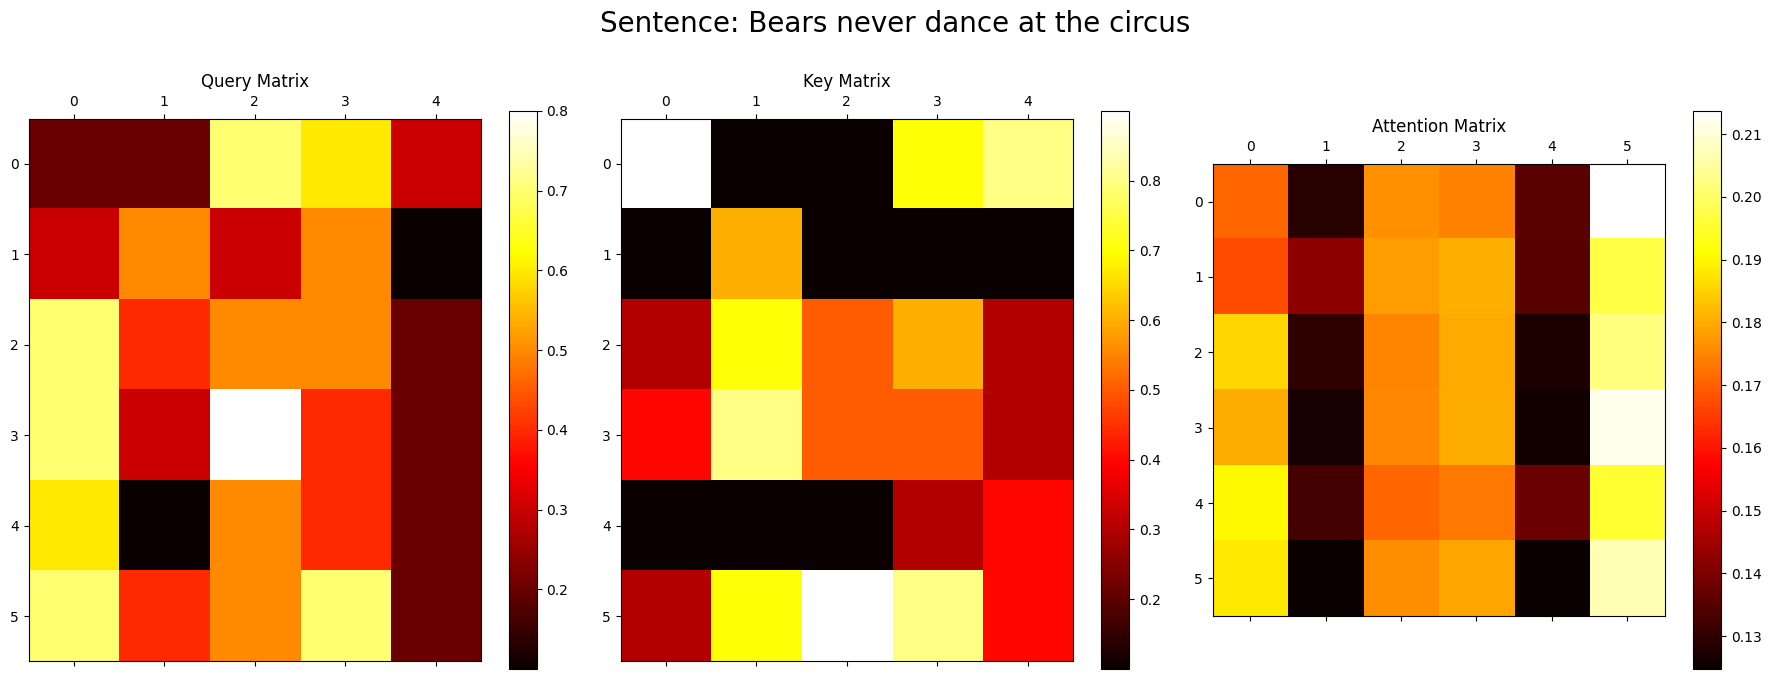

In [ ]:
import torch
import torch.nn.functional as F
questions = ["Who","When","Where","What","How Many"]
sentence = "Bears never dance at the circus"
tokens = sentence.split(" ")
# embed_size = d_model = 5
# context_len = 6
T,C = (len(tokens),5)
query = [
    [2,2,7,6,3], # Bears
    [3,5,3,5,1], # never
    [7,4,5,5,2], # dance
    [7,3,8,4,2], # at
    [6,1,5,4,2], # the
    [7,4,5,7,2], # circus
                ]

key = [
    [9,1,1,7,8], # Bears
    [1,6,1,1,1], # never
    [3,7,5,6,3], # dance
    [4,8,5,5,3], # at
    [1,1,1,3,4], # the
    [3,7,9,8,4], # circus
    ]

value = [
    [9,1,1,7,8], # Bears
    [1,6,1,1,1], # never
    [3,7,5,6,3], # dance
    [4,8,5,5,3], # at
    [1,1,1,3,4], # the
    [3,7,9,8,4], # circus
    ]

query = torch.tensor(query)/10
key = torch.tensor(key)/10
value = torch.tensor(value)/10

att = F.softmax((query @ key.T)/(C**0.5),dim=1)

print("Query Matrix: \n",query,"\n")
print("Key Matrix: \n",key,"\n")
print("Attention Matrix: \n",att,"\n")
vis1(query=query, key=key, attn_weights=att, text=sentence, cmap_val="hot")

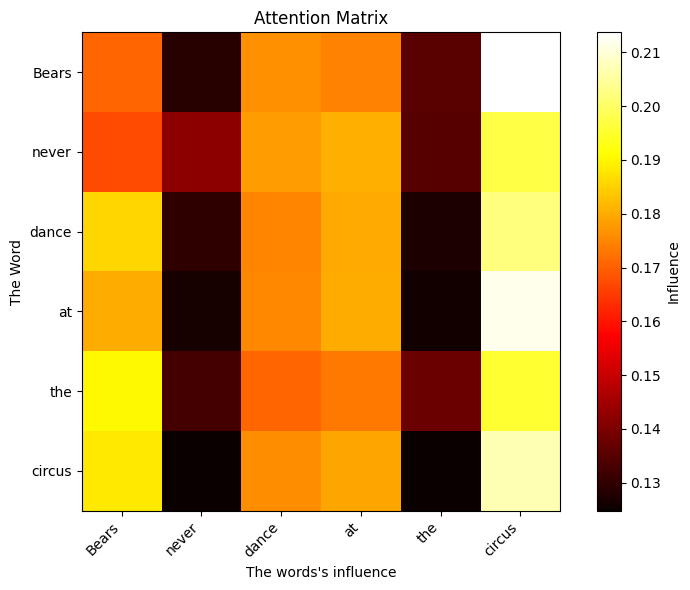

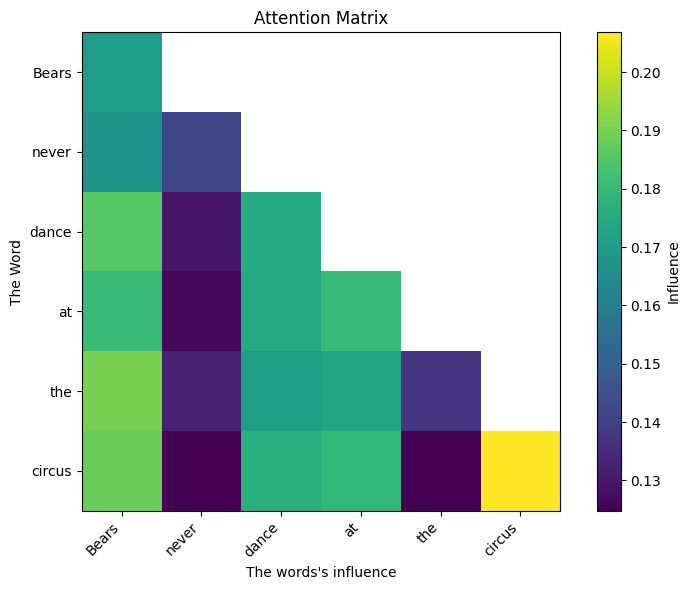

In [ ]:
vis2(attn_weights=att,text=sentence,cmap_val="hot")
mask = torch.tril(torch.ones(T,T))
mask
vis2(attn_weights=torch.masked_fill(att, mask==0,float("-inf")),text=sentence)



Attention Matrix: 
 tensor([[0.1709, 0.1289, 0.1763, 0.1747, 0.1354, 0.2137],
        [0.1672, 0.1423, 0.1780, 0.1804, 0.1349, 0.1973],
        [0.1856, 0.1298, 0.1751, 0.1799, 0.1275, 0.2021],
        [0.1802, 0.1266, 0.1754, 0.1802, 0.1260, 0.2117],
        [0.1902, 0.1324, 0.1709, 0.1732, 0.1379, 0.1954],
        [0.1883, 0.1248, 0.1761, 0.1793, 0.1248, 0.2068]]) 

Value Matrix: 
 tensor([[0.9000, 0.1000, 0.1000, 0.7000, 0.8000],
        [0.1000, 0.6000, 0.1000, 0.1000, 0.1000],
        [0.3000, 0.7000, 0.5000, 0.6000, 0.3000],
        [0.4000, 0.8000, 0.5000, 0.5000, 0.3000],
        [0.1000, 0.1000, 0.1000, 0.3000, 0.4000],
        [0.3000, 0.7000, 0.9000, 0.8000, 0.4000]]) 

Context_vector: 
 tensor([[0.3671, 0.5208, 0.4114, 0.5373, 0.3946],
        [0.3629, 0.5226, 0.4012, 0.5265, 0.3883],
        [0.3779, 0.5171, 0.4037, 0.5378, 0.3998],
        [0.3756, 0.5217, 0.4116, 0.5413, 0.3985],
        [0.3774, 0.5072, 0.3940, 0.5332, 0.4020],
        [0.3810, 0.5176, 0.4076, 0.5424, 0

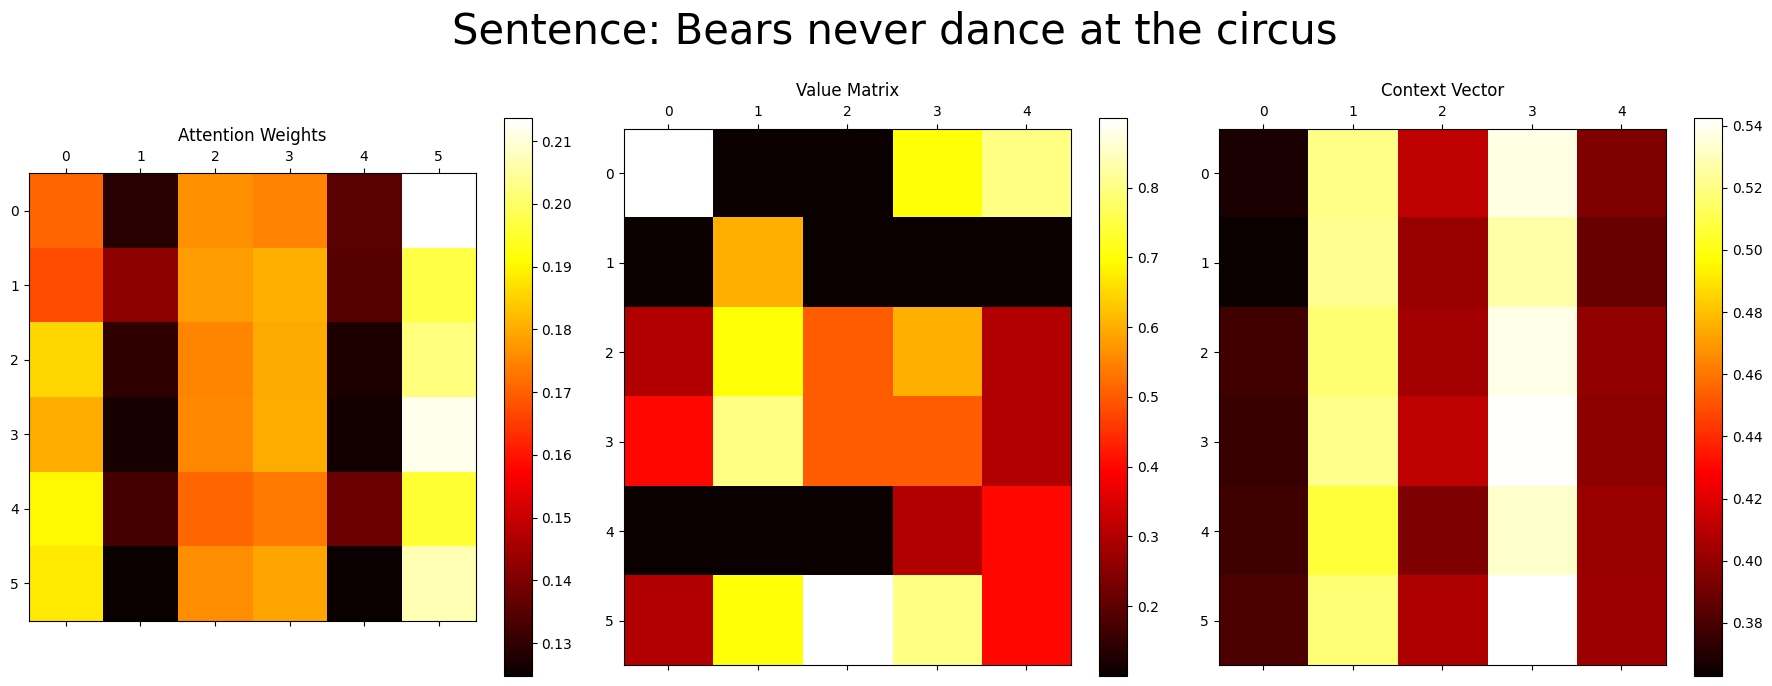

In [ ]:
print("Attention Matrix: \n",att,"\n")
print("Value Matrix: \n",value,"\n")
context_vector = att @ value
print("Context_vector: \n",context_vector,"\n")
vis3(value=value,attn_weights=att,context_vector=context_vector,text=sentence, cmap_val="hot")

 #### 1.3. Self-Attention (Single-Head)

 Bu bölümde Self-Head Attention katmanını uygulayacağız. Öncelikle basit bir uygulamayla işlemi anlayalım

In [ ]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.d_model = d_model
        self.head_size = head_size
        self.query = nn.Linear(d_model, head_size, bias=False)
        self.key = nn.Linear(d_model, head_size, bias=False)
        self.value = nn.Linear(d_model, head_size, bias=False)

    def forward(self, x):
        B,T,C = x.shape
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        att = F.softmax((query @ key.T)/(self.head_size**0.5),dim=1)
        context_vector = att @ value
        return context_vector

 #### 1.3. Multi Head Attention

 Bu bölümde Multi Head Attention katmanını uygulayacağız. Çoklu kafa dikkat katmanı, $h$ adet dikkat başlığına sahiptir. Her dikkat başlığının ayrı bir sorgu, anahtar ve değer matrisi vardır.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        # d_model'in num_heads'e bölünebilir olup olmadığını kontrol ediyoruz
        assert d_model % num_heads == 0, "d_model num_heads'e bölünebilmelidir"

        # Her başlığa d_model'in num_heads'e bölünmüş boyutunu atamak için d_model'i num_heads'e bölüyoruz. Bu hem d_k hem de d_v için geçerlidir
        self.d_qkv = d_model // num_heads

        # Sorguları, anahtarları ve değerleri projekte etmek için nn.Linear kullanıyoruz. Aynı lineer projeksiyonu tüm başlıklar için kullanıyoruz.
        # Bunun nedeni, sorguları, anahtarları ve değerleri projekte etmek için ayrı ayrı matrisler kullanmak yerine tek bir matris çarpımı kullanmamıza olanak tanımasıdır.
        # Bu, her biri için ayrı matrisler kullanmaktan daha verimlidir.
        self.W_keys = nn.Linear(d_model, d_model, bias=False)
        self.W_queries = nn.Linear(d_model, d_model, bias=False)
        self.W_values = nn.Linear(d_model, d_model, bias=False)

        # Çıktıyı projekte etmek için tek bir lineer projeksiyon kullanıyoruz
        self.linear_proj = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, key_src, query_src, value_src, mask=None):

        # Girdi yığınının şeklini alıyoruz
        B,T,C = key_src.shape # (batch_size, seq_len, d_model)


        # Sorguları, anahtarları ve değerleri ilgili ağırlık matrislerini kullanarak projekte ediyoruz
        keys = self.W_keys(key_src) # (batch_size, seq_len, d_model)
        queries = self.W_queries(query_src) # (batch_size, seq_len, d_model)
        values = self.W_values(value_src) # (batch_size, seq_len, d_model)


        # Sorguları, anahtarları ve değerleri çoklu başlıklara bölmek için yeniden şekillendiriyoruz

        keys = keys.view(B,T,self.num_heads,self.d_qkv) # (batch_size, seq_len, num_heads, d_qkv)
        queries = queries.view(B,T,self.num_heads,self.d_qkv) # (batch_size, seq_len, num_heads, d_qkv)
        values = values.view(B,T,self.num_heads,self.d_qkv) # (batch_size, seq_len, num_heads, d_qkv)


        # Sorguları, anahtarları ve değerleri tensörün şeklini (batch_size, num_heads, seq_len, d_qkv) yapacak şekilde yer değiştiriyoruz

        keys = keys.transpose(1,2) # (batch_size, num_heads, seq_len, d_qkv)
        queries = queries.transpose(1,2) # (batch_size, num_heads, seq_len, d_qkv)
        values = values.transpose(1,2) # (batch_size, num_heads, seq_len, d_qkv)

        # Dikkat puanlarını hesaplıyoruz.
        atn_scr = queries @ keys.transpose(-2,-1) # (batch_size, num_heads, seq_len, seq_len)
        # Dikkat puanlarını ölçeklendiriyoruz ve maskeyi uyguluyoruz (varsa)
        scaled_atn_scr = atn_scr / self.d_qkv**-0.5
        if mask is not None:
            scaled_atn_scr = scaled_atn_scr.masked_fill(mask==0,float('-inf'))

        # Dikkat ağırlıklarını hesaplamak için softmax aktivasyonunu uyguluyoruz
        attention_weights = torch.softmax(scaled_atn_scr, dim=-1)
        attention_weights = self.dropout(attention_weights)  # Dropout uyguluyoruz
        # Son olarak, dikkat ağırlıklarını değerlerle çarpıyoruz
        out = attention_weights @ values
        out = out.transpose(1, 2) # (batch_size, seq_len, num_heads, d_qkv)
        # Matrisi (batch_size, seq_len, d_model) şekline dönüştürmek için yeniden şekillendiriyoruz
        out = out.reshape(B, T, C) # (batch_size, seq_len, d_model)
        # Bir sonraki katmana beslemek için son bir lineer projeksiyon uyguluyoruz
        out = self.linear_proj(out)
        return out


 #### 1.4. İleri Beslemeli Sinir Ağı

 Bu bölümde makalede olduğu gibi FFN'yi uygulayacağız. Bu, ağın içinde 2 lineer katman ve bu katmanlar arasında ReLU aktivasyon fonksiyonunun olduğu anlamına gelir. Ağın giriş ve çıkış boyutu aynı kalır, ancak içeride boyutu bir katsayı ile çarpmak üzere artırırız, bu katsayıya "Forward Expansion" denir.

In [ ]:
class FeedForwardNet(nn.Module):
    def __init__(self, d_model, forward_expansion, dropout=0.1):
        super(FeedForwardNet, self).__init__()
        # İlk lineer katmanın çıkış boyutu forward_expansion kez d_model (d_model*forward_expansion)
        self.fc1 = nn.Linear(d_model, int(d_model * forward_expansion))
        self.relu = nn.ReLU()
        # İkinci lineer katmanın giriş boyutu d_model * forward_expansion ve çıkışı sadece d_model'dir
        # İleri beslemeli ağa giren girdinin boyutunu aynı tutabilmek ve artıklı bağlantı kullanabilmek için
        self.fc2 = nn.Linear(int(d_model * forward_expansion), d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

 #### 1.5. Encoder Stack

 Bu bölümde Encoder Stack oluşturacağız. Encoder Stack 1 MHA ve 1 FFN bloğundan oluşur. Bu bloğun her alt birimini Layer Normalization ve Residual Connection takip eder.

In [ ]:
class EncoderStack(nn.Module):
    def __init__(self, d_model, num_heads, forward_expansion, dropout=0.1):
        super().__init__()
        self.MHA = MultiHeadAttention(d_model=d_model, num_heads=num_heads, dropout=dropout)
        self.FFN = FeedForwardNet(d_model=d_model, forward_expansion=forward_expansion, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)  # Dropout katmanı eklendi
        self.dropout2 = nn.Dropout(dropout)  # Dropout katmanı eklendi

    def forward(self, x):
        out = x + self.dropout1(self.MHA(x, x, x))  # Dropout uyguluyoruz + Residual connection
        norm_out = self.layer_norm1(out) # Layer Normalization uyguluyoruz
        out = norm_out + self.dropout2(self.FFN(norm_out))  # Dropout uyguluyoruz + Residual connection
        norm_out = self.layer_norm2(out) # Layer Normalization uyguluyoruz
        return norm_out

 #### 1.6. Encoder

 Bu bölümde Encoder bloğunu oluşturuyoruz. Encoder bloğu bir Embedding katmanı ve N adet Encoder Stack bloğundan (N = num_layers) oluşur.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, block_size, d_model, num_heads, forward_expansion, num_layers):
        super().__init__()
        self.block_size = block_size
        self.d_model = d_model
        self.embeding_layer = EmbeddingLayer(d_model, vocab_size, block_size)
        self.layers = nn.ModuleList([EncoderStack(d_model, num_heads, forward_expansion) for _ in range(num_layers)])

    def forward(self, x):
        x = self.embeding_layer(x)
        for layer in self.layers:
            x = layer(x)
        return x

 #### 1.7. Decoder Stack

 Bu bölümde Decoder Stack bloğunu oluşturacağız. Decoder Stack bloğu, 2 MHA (birisi maskelemeli dikkat, diğeri çapraz dikkat için) ve 1 FFN bloğundan oluşur. Bu bloğun da her alt birimini Layer Normalization ve Residual Connection takip eder.

In [ ]:
class DecoderStack(nn.Module):
    def __init__(self, d_model, num_heads, forward_expansion, dropout=0.1):
        super(DecoderStack, self).__init__()
        self.Masked_MHA = MultiHeadAttention(d_model=d_model, num_heads=num_heads, dropout=dropout)
        self.Crossed_MHA = MultiHeadAttention(d_model=d_model, num_heads=num_heads, dropout=dropout)
        self.FFN = FeedForwardNet(d_model=d_model, forward_expansion=forward_expansion, dropout=dropout)
        self.LayerNorm1 = nn.LayerNorm(d_model)
        self.LayerNorm2 = nn.LayerNorm(d_model)
        self.LayerNorm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_out, trg_mask):
        masked_att_out = self.dropout1(self.Masked_MHA(key_src=x, query_src=x, value_src=x, mask=trg_mask))
        masked_att_out = self.LayerNorm1(masked_att_out + x)
        crossed_att_out = self.dropout2(self.Crossed_MHA(key_src=encoder_out, query_src=masked_att_out, value_src=encoder_out))
        crossed_att_out = self.LayerNorm2(crossed_att_out + masked_att_out)
        ffn_out = self.dropout3(self.FFN(crossed_att_out))
        ffn_out = self.LayerNorm3(ffn_out + crossed_att_out)
        return ffn_out

 #### 1.8. Decoder

 Bu bölümde Decoder bloğunu oluşturuyoruz. Decoder bloğu bir Embedding katmanı ve N adet Decoder Stack bloğundan (N = num_layers) oluşur.

In [ ]:
class Decoder(nn.Module):
    def __init__(self,vocab_size, context_len, d_model, num_heads, forward_expansion, num_layers):
        super().__init__()
        self.context_len = context_len
        self.d_model = d_model
        self.embeding_layer = EmbeddingLayer(d_model, vocab_size, context_len)
        self.layers = nn.ModuleList([DecoderStack(d_model, num_heads, forward_expansion) for _ in range(num_layers)])

    def forward(self, x, encoder_output, trg_mask):
        x = self.embeding_layer(x)
        for layer in self.layers:
            x = layer(x, encoder_output, trg_mask)
        return x


 #### 1.9. Transformer

 Son olarak, Transformer modelini oluşturuyoruz. Transformer modeli, Encoder ve Decoder bloklarının birleşiminden oluşur. Encoder, Embedding katmanı ve N adet Encoder Stack katmanından oluşur. Decoder ise Embedding katmanını ve N adet Decoder Stack katmanından oluşur. En son da bu modelin ucuna çıktı boyutu Tokenizer'ın öğrendiği kelime sayısına eşit bir lineer katman koyarız. Bu son katman sayesinde Decoder'dan aldığımız çıktıyı tahmin yapabilmek için kullanılabilecek hale getirebilriz.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, eng_vocab_size,fr_vocab_size, block_size, d_model, nhead, num_encoder_layers, num_decoder_layers,
                 forward_expansion, learning_rate, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(eng_vocab_size, block_size, d_model, nhead, forward_expansion, num_encoder_layers)
        self.decoder = Decoder(fr_vocab_size, block_size, d_model, nhead, forward_expansion, num_decoder_layers)

        self.d_model = d_model
        self.linear = nn.Linear(d_model, fr_vocab_size)

    def forward(self, src, trg, src_mask=None, trg_mask=None):
        encoder_output = self.encoder(src)
        decoder_output = self.decoder(trg, encoder_output, trg_mask) # (batch_size, context_len, d_model)
        output = self.linear(decoder_output) # (batch_size, context_len, fr_vocab_size)
        return output


In [ ]:
eng_vocab_size= 12000
fr_vocab_size= 12000
context_len = 512
d_model=1024
nhead=16
num_encoder_layers=6
num_decoder_layers=6
forward_expansion=4
learning_rate= 1e-4
dropout=0.3
transformer= Transformer(eng_vocab_size, fr_vocab_size,context_len, d_model, nhead, num_encoder_layers, num_decoder_layers,
                 forward_expansion, learning_rate, dropout=dropout).to(device)

print((sum(p.numel() for p in transformer.parameters()))/10**6," M parameters")

213.17808  M parameters
